Moving through the world depends on our ability to perceive and interpret visual information, with optic flow playing a crucial role. Optic flow - the pattern of motion we see as we move - provides essential cues for self-motion and navigation, helping us to determine our direction, speed and the structure of our environment. By targeting the focal point of expansion within this flow, we can accurately orient ourselves and adjust our trajectory.

In this exploration, we will generate a synthetic optic flow to challenge and examine how the visual system captures the focus of expansion. This will not only deepen our understanding of visual perception, but also highlight the practical importance of optic flow in everyday navigation, from avoiding obstacles to maintaining stability. By mastering the interpretation of optic flow, we enhance our spatial awareness and mobility, making it a vital skill for interacting with our dynamic world.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [ ]:
import os

import numpy as np
import torch
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
fig_width = 15
dpi = 'figure'
dpi = 200
opts_savefig = dict(dpi=dpi, bbox_inches='tight', pad_inches=0, edgecolor=None)

image_size_grid = 257

## creating an optic flow

Creating an optic flow can be straightforward using a procedural algorithm. This involves placing static visual objects, such as stars, within a 3D environment and then moving the camera (representing the viewer's perspective) through this space, for example, along a straight line.

See for instance 
https://github.com/NaturalPatterns/StarField
for an easy way to generate such plots.


![alt text](https://raw.githubusercontent.com/NaturalPatterns/StarField/master/starfield.gif)


In this specific example, you observe that the motion of individual objects within the global optic flow converges on a single point, known as the focus of expansion (FoE). This convergence is a crucial emergent property of optic flow. We will explore manipulating scenarios where the FoE is not centrally located within the image. By doing so, we aim to simulate the perception of slightly sideways motion, which occurs when the direction of movement is not perfectly aligned with the center of the visual field. This approach will allow us to examine how the visual system adapts to and interprets off-center optic flow patterns.

To create a more natural and immersive optic flow, we will employ a different procedure that involves using a random texture mapped onto the surface of a cylinder. This approach simulates the visual experience of moving through a tunnel. The optic flow will be generated by simulating movement within this cylindrical environment, where the texture's perspective and motion dynamics mimic real-world visual cues. This method enhances the realism of the optic flow by providing a continuous and coherent visual field, allowing for a more authentic perception of self-motion.

![alt text](https://cdn.pixabay.com/photo/2013/03/16/01/30/cave-94193_1280.jpg)

This means we need to map the texture onto visual coordinates defined for a cylindrical surface. Given that we will perform transformations such as changing the view axis through simple translations later, we'll assume our gaze is aligned with the cylinder's axis. In a previous post, [Implementing a Retinotopic Transform Using grid_sample from PyTorch](https://laurentperrinet.github.io/sciblog/posts/2023-02-02-implementing-a-retinotopic-transform-using-grid_sample-from-pytorch.html), we modeled the retinotopic transform, which involves converting the visual field into retinotopic coordinates. This process is conceptually similar but in reverse. Therefore, we can leverage the same tools by designing new coordinates that accommodate the cylindrical mapping, ensuring a seamless and accurate transformation of the visual input. 


### definition of the grid

Let's first define a first grid as a set of points defined in absolute coordinates between $-1$ and $1$, and define the corresponding meshgrid:

In [ ]:
image_size_grid_az, image_size_el = 360, 400
image_size_az, image_size_el = 360, 360

rs_ = torch.logspace(0, -4, image_size_az, base=2)
ts_ = torch.linspace(-torch.pi, torch.pi, image_size_el+1)[:-1]

grid_xs = torch.outer(rs_, -torch.cos(ts_)) 
grid_ys = torch.outer(rs_, torch.sin(ts_)) 
grid_xs.shape, grid_ys.shape

In [ ]:
F.grid_sample?

In [8]:
%pip install -U  tikz-python

Note: you may need to restart the kernel to use updated packages.


In [12]:
from tikzpy import TikzPicture  # Import the class TikzPicture

tikz = TikzPicture()
tikz.circle((0, 0), 3, options="thin, fill=orange!15")

arc_one = tikz.arc((3, 0), 0, 180, x_radius=3, y_radius=1.5, options="dashed")
arc_two = tikz.arc((-3, 0), 180, 360, x_radius=3, y_radius=1.5)

# tikz.show()  # Displays a pdf of the drawing to the user
print(tikz)


\begin{tikzpicture}
    \draw[thin, fill=orange!15] (0, 0) circle (3cm);
    \draw[dashed] (3, 0) arc [start angle = 0.0, end angle = 179.99999999999997, x radius = 3cm, y radius = 1.5cm];
    \draw (-3, 0) arc [start angle = 179.99999999999997, end angle = 359.99999999999994, x radius = 3cm, y radius = 1.5cm];
\end{tikzpicture}



In [4]:
from tikz import *

ModuleNotFoundError: No module named 'tikz'

In [14]:
%pip install git+https://github.com/michakraus/ipython-tikzmagic.git

  Cloning https://github.com/michakraus/ipython-tikzmagic.git to /private/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/pip-req-build-qvi2c861
  Running command git clone --filter=blob:none --quiet https://github.com/michakraus/ipython-tikzmagic.git /private/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/pip-req-build-qvi2c861
  Resolved https://github.com/michakraus/ipython-tikzmagic.git to commit 741a199733ddb875b652a63774b696b48f67b1f4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [15]:
%load_ext tikzmagic

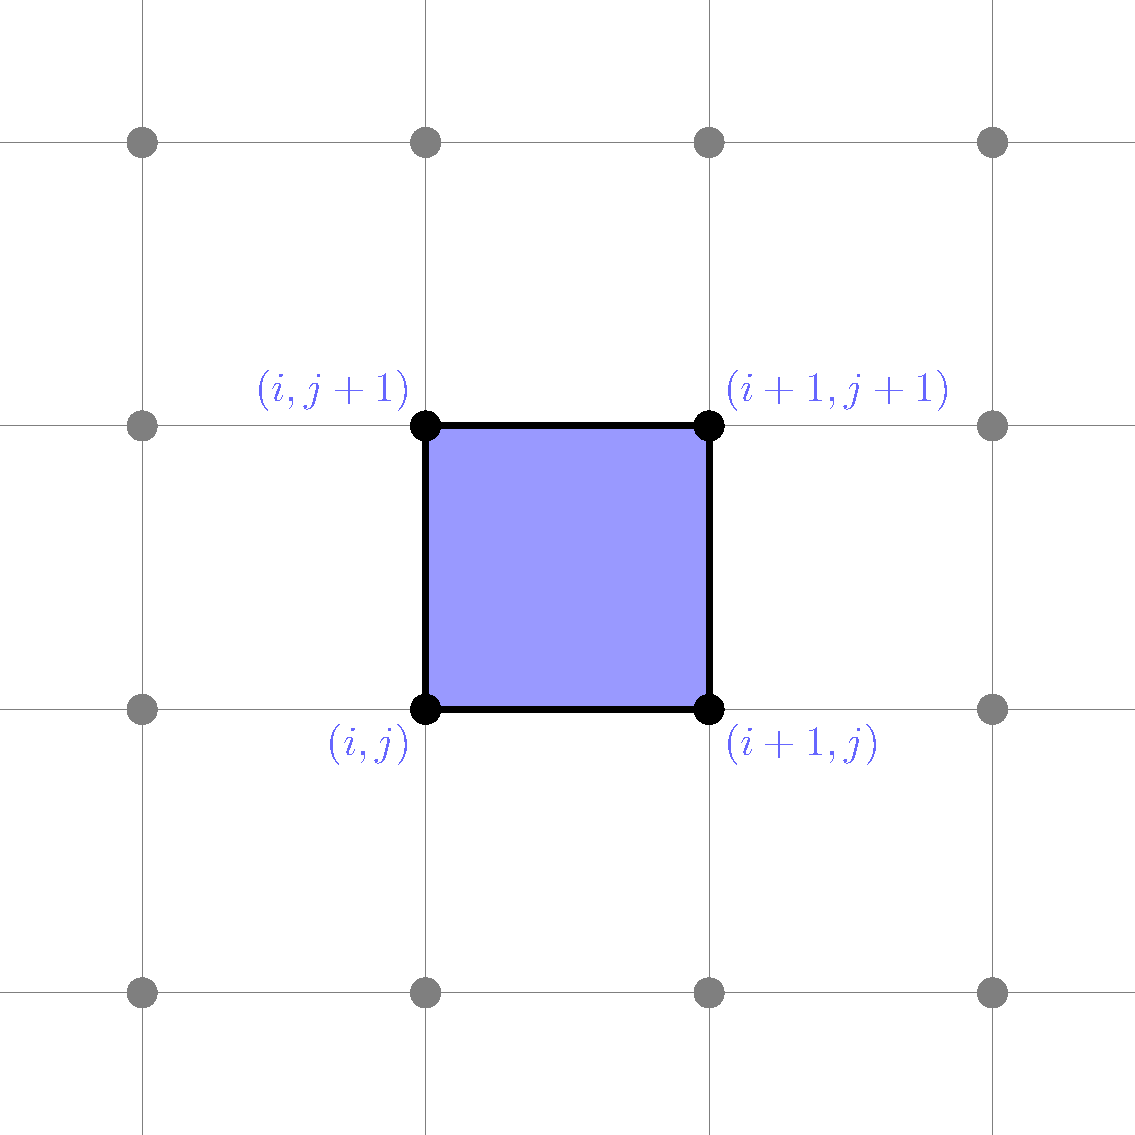

In [17]:
%%tikz -s 400,400 -sc 1.2 -f png
\draw [style=help lines, step=2]                (-1,-1)    grid        (+7,+7);
\draw [line width=0.5mm, fill=blue!40!white]    (+2,+2)    rectangle    (+4,+4);
 
\draw [blue!60!white] (  2,  2) node[anchor=north east] {$(i  ,j  )$};
\draw [blue!60!white] (  4,  2) node[anchor=north west] {$(i+1,j  )$};
\draw [blue!60!white] (  4,  4) node[anchor=south west] {$(i+1,j+1)$};
\draw [blue!60!white] (  2,  4) node[anchor=south east] {$(i  ,j+1)$};

\filldraw [color=gray]    (0,0) circle (.1);
\filldraw [color=gray]    (0,2) circle (.1);
\filldraw [color=gray]    (0,4) circle (.1);
\filldraw [color=gray]    (0,6) circle (.1);
\filldraw [color=gray]    (2,0) circle (.1);
\filldraw [color=black]    (2,2) circle (.1);
\filldraw [color=black]    (2,4) circle (.1);
\filldraw [color=gray]    (2,6) circle (.1);
\filldraw [color=gray]    (4,0) circle (.1);
\filldraw [color=black]    (4,2) circle (.1);
\filldraw [color=black]    (4,4) circle (.1);
\filldraw [color=gray]    (4,6) circle (.1);
\filldraw [color=gray]    (6,0) circle (.1);
\filldraw [color=gray]    (6,2) circle (.1);
\filldraw [color=gray]    (6,4) circle (.1);
\filldraw [color=gray]    (6,6) circle (.1);



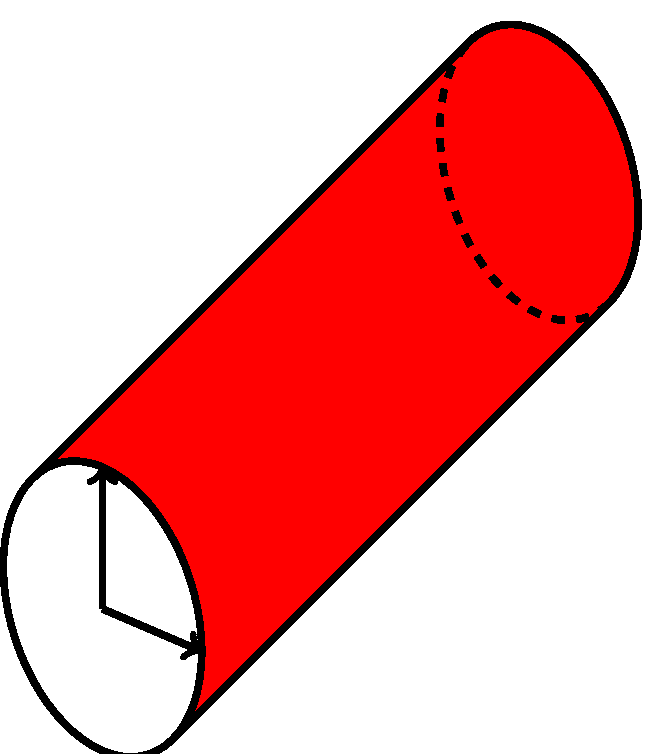

In [21]:
%%tikz -s 400,400 -sc 1.2  -f png

\begin{scope}[x={(.7cm,-.3cm)}]
\path (1,0,0);
\pgfgetlastxy{\cylxx}{\cylxy}
\path (0,1,0);
\pgfgetlastxy{\cylyx}{\cylyy}
\path (0,0,1);
\pgfgetlastxy{\cylzx}{\cylzy}
\pgfmathsetmacro{\cylt}{(\cylzy * \cylyx - \cylzx * \cylyy)/ (\cylzy * \cylxx - \cylzx * \cylxy)}
\pgfmathsetmacro{\ang}{atan(\cylt)}
\pgfmathsetmacro{\ct}{1/sqrt(1 + (\cylt)^2)}
\pgfmathsetmacro{\st}{\cylt * \ct}
\fill[red] (\ct,\st,0) -- ++(0,0,-8) arc[start angle=\ang,delta angle=180,radius=1] -- ++(0,0,8) arc[start angle=\ang+180,delta angle=-180,radius=1];
\begin{scope}[every path/.style={ultra thick}]
\draw (0,0,0) circle[radius=1];
\draw[->] (0,0,0) -- (1,0,0);
\draw[->] (0,0,0) -- (0,1,0);
\draw (\ct,\st,0) -- ++(0,0,-8);
\draw (-\ct,-\st,0) -- ++(0,0,-8);
\draw (\ct,\st,-8) arc[start angle=\ang,delta angle=180,radius=1];
\draw[dashed] (\ct,\st,-8) arc[start angle=\ang,delta angle=-180,radius=1];
\end{scope}
\end{scope}

Let's first define the Great-circle distance to transform the azimuth and elevation into a deviation angle from the gaze axis:

In [ ]:
# see https://github.com/NaturalPatterns/2013_Tropique/blob/master/modele_dynamique.py#L20
def arcdistance(rae1, rae2):
    """
    Returns the angle on the great circle (in radians)

    # rae1 ---> rae2

    r = distance from the center of spherical coordinates (meters)
    a = azimuth = declination = longitude (radians)
    e = elevation = right ascension = latitude (radians)

    http://en.wikipedia.org/wiki/Great-circle_distance
    http://en.wikipedia.org/wiki/Vincenty%27s_formulae
    
    """
    a =  (np.cos(rae2[2, ...]) * np.sin(rae2[1, ...] - rae1[1, ...]))**2
    a += (np.cos(rae1[2, ...]) * np.sin(rae2[2, ...]) -  np.sin(rae1[2, ...]) *  np.cos(rae2[2, ...]) * np.cos(rae2[1, ...] - rae1[1, ...]))**2
    b =   np.sin(rae1[2, ...]) * np.sin(rae2[2, ...]) +  np.cos(rae1[2, ...]) *  np.cos(rae2[2, ...]) * np.cos(rae2[1, ...] - rae1[1, ...])

    return np.arctan2(np.sqrt(a), b)


These are then formated in the right format to be used by the function:

In [ ]:
center_x, center_y = 0., 0. # defines the fixation point's center in absolute coordinates
logPolar_grid = torch.stack((grid_xs-center_x, grid_ys-center_y), 2)
logPolar_grid = logPolar_grid.unsqueeze(0) # add batch dim
logPolar_grid.shape

In [ ]:
logPolar_grid.min()

In [ ]:
# F.grid_sample?

### application to a synthetic image

We define a synthetic image to illustrate the transform, it consists of white pixels, red verticals and blue horizontals, regularly spaced:

In [ ]:
image_grid_size = 8
image_grid_tens = torch.ones((3, image_size_grid, image_size_grid)).float()
image_grid_tens[0:2, ::image_grid_size, :] = 0
image_grid_tens[1:3, :, ::image_grid_size] = 0
fovea_size = 5
image_grid_tens[[0, 2], 
                int(image_size_grid//2+image_grid_size*fovea_size/2.5):int(image_size_grid//2+image_grid_size*fovea_size), 
                int(image_size_grid//2+image_grid_size*fovea_size/2.5):int(image_size_grid//2+image_grid_size*fovea_size), 
                ] = 0
image_grid_tens[[0, 2], 
                int(image_size_grid//2+image_grid_size*fovea_size):int(image_size_grid//2+image_grid_size*fovea_size*2), 
                int(image_size_grid//2-image_grid_size*fovea_size*2):int(image_size_grid//2-image_grid_size*fovea_size), 
                ] = 0
image_grid_tens[:, (image_size_grid//2-image_grid_size*fovea_size):(image_size_grid//2+image_grid_size*fovea_size), (image_size_grid//2-image_grid_size*fovea_size):(image_size_grid//2+image_grid_size*fovea_size)] *= .5
image_grid_tens.shape, image_grid_tens.unsqueeze(0).shape

to display it, we need to transform the torch format to a numpy / matplotlib compatible one, which can be first tested on a MWE (minimal working example) using `torch.movedim`:

In [ ]:
torch.movedim(torch.randn(1, 2, 3), (0, 1, 2), (1, 2, 0)).shape

this can be done on the image in a few lines:

In [ ]:
image_grid = image_grid_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_grid = torch.movedim(image_grid, (1, 2, 0), (0, 1, 2))
image_grid = image_grid.numpy()
image_grid.shape

so that we can display the synthetic image:

In [ ]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_grid)
ax.plot(image_size_grid//2, image_size_grid//2, 'r+', markersize=40, markeredgewidth=5)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

Let's transform the image of the grid:

In [ ]:
image_grid_ret_tens = F.grid_sample(image_grid_tens.unsqueeze(0).float(), logPolar_grid, align_corners=False, padding_mode='border')
image_grid_tens.shape, logPolar_grid.shape, image_grid_ret_tens.shape

and transform it back to numpy:

In [ ]:
image_grid_ret_tens = image_grid_ret_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_grid_ret_tens = torch.movedim(image_grid_ret_tens, (1, 2, 0), (0, 1, 2))
image_grid_ret = image_grid_ret_tens.numpy()
image_grid_ret /= image_grid_ret.max()
image_grid_ret.shape

to then display the retinotopic transform of the grid image:

In [ ]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_grid_ret)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

## some book keeping for the notebook

In [ ]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,scipy,pillow,imageio  -r -g -b